# IFT 6135 - Assignment 1
## Authors: Manish Jha, Shivendra Bhardwaj, Tapopriya Majumdar

In [ ]:
# the code is also available at https://github.com/kumarmanishjha/6135_1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle

%matplotlib inline

## Question 1

Here we implement our version of the MLP. with multiple hidden layers as a class ``NN``. For the MNIST dataset, we choose a network with two hidden layers: $h^1=512$ and $h^2=1024$, so that the total number of parameters is $937482$. The method ``initialize_params`` initializes the weight and bias parameters according to the three options: ``zero``, ``normal`` or ``glorot``.

In [ ]:
class NN:
    """Our implementation of a Neural Network"""
    
    def __init__(self, hidden_dims=(1024, 2048), n_hidden=2,
                 mode='train', datapath=None, model_path=None):
        """
        Initialize an MLP instance
        """
        # input check
        assert len(hidden_dims) == n_hidden, "Check input data!"
        assert mode in ['train', 'test'], "Check input data!"
        for d in hidden_dims:
            assert isinstance(d, int) & (d > 0), "Check input data!"
        self.n_hidden = n_hidden
        if mode == 'train':
            # load the pickled data
            with gzip.open(datapath, 'rb') as f:
                data = pickle.load(f, encoding='latin-1')
            # construct the training, validation 
            # and test datasets
            (self.X_train, self.y_train), \
                (self.X_valid, self.y_valid), \
                (self.X_test, self.y_test) = data

            # store the dimensions
            self.dims = [self.X_train.shape[1]] + list(hidden_dims) \
                                                + [len(set(self.y_train))]
            self.n_classes = self.dims[-1]

    def initialize_weights(self, init_method='glorot', seed=False):
        """
        Intialize the weights and biases
        according to the initialization method
        """
        assert init_method in ['zero', 'normal', 'glorot'], \
                                                "Check input data!"
        params = {}  #  dictionary to store weights and biases
        n_params = 0  # running counter for parameters
        if seed:  # for reproducibility
            np.random.seed(seed)
        if init_method == 'zero':
            for i in range(self.n_hidden+1):
                # zero matrices and vectors
                W = np.zeros((self.dims[i+1], self.dims[i]))
                b = np.zeros((self.dims[i+1], 1))
                n_params += W.size + b.size
                # params update
                params.update({"W"+str(i+1): W, "b"+str(i+1): b})

        elif init_method == 'normal':
            for i in range(self.n_hidden+1):
                # sample from normal
                #W = np.random.normal(size=(self.dims[i+1], self.dims[i]))
                W = np.random.randn(self.dims[i+1], self.dims[i])
                b = np.zeros((self.dims[i+1], 1))  # zero vector
                n_params += W.size + b.size
                # params update
                params.update({"W"+str(i+1): W, "b"+str(i+1): b})

        elif init_method == 'glorot':
            for i in range(self.n_hidden+1):
                # sample from uniform [-di, di]
                di = np.sqrt(6 /(self.dims[i] + self.dims[i+1]))
                W = np.random.uniform(low=-di, high=di,
                                      size=(self.dims[i+1], self.dims[i]))
                b = np.zeros((self.dims[i+1], 1))  # zero vector
                n_params += W.size + b.size
                # params update
                params.update({"W"+str(i+1): W, "b"+str(i+1): b})
        
        # store number of parameters as well
        params.update({"n_params": n_params})
        return params

    def activation(self, z, function="relu"):
        """Computing different activation functions"""
        assert function in ["relu", "sigmoid", "tanh"], \
                                "Check your activation function!"
            
        if function == "relu":
            return np.maximum(z, 0)
        
        elif function == "sigmoid":
            # numerically stable
            return np.where(z >= 0, 
                            1 / (1 + np.exp(-z)), 
                            np.exp(z) / (1 + np.exp(z)))
        
        elif function == "tanh":
            #numerically stable
            return np.where(z >= 0, 
                            (1 - np.exp(-2*z)) / (1 + np.exp(-2*z)), 
                            (np.exp(2*z) - 1) / (np.exp(2*z) + 1))

    def softmax(self, X):
        """Numerically stable softmax"""
        X_max = np.max(X, axis=0, keepdims=True)
        exp_X = np.exp(X - X_max)
        return exp_X / np.sum(exp_X, axis=0, keepdims=True)

    def loss(self, y, y_hat):
        """Compute the cross-entropy loss for multiple entries"""
        #print(min(y_hat[y, range(len(y))]), max(y_hat[y, range(len(y))]))
        probs = y_hat[y, range(len(y))]
        probs[probs == 0] = 1e-3
        return -np.log(probs)

    def forward(self, X, params, activation_function='relu'):
        """Forward propagation"""
        cache = {}  # dictionary to store the outputs
        # start with the data (transpose for convenience)
        Z = X.T
        for i in range(self.n_hidden+1):  # hidden layers
            # retrieve the relevant parameters
            W = params["W"+str(i+1)]
            b = params["b"+str(i+1)]
            # affine transformation & nonlinearity
            A = np.dot(W, Z) + b  
            if i != self.n_hidden:
                Z = self.activation(A, function=activation_function)
            else:
                Z = self.softmax(A)
            # update the cache
            cache.update({"A"+str(i+1): A, "Z"+str(i+1): Z})
        return cache

    def backward(self, X, y, params, cache, activation_function="relu"):
        """Backward Propagation"""
        grads = {}  # store gradients
        # gradient wrt the softmax function
        eye_mat = np.zeros((self.n_classes, len(y)))
        for j in range(len(y)):
            eye_mat[y[j], j] = 1
        grad_A = cache["Z"+str(self.n_hidden+1)] - eye_mat
        # update parameter gradients
        for i in range(self.n_hidden+1, 0, -1):
            # define Z using cases
            Z = cache["Z"+str(i-1)] if i != 1 else X.T 
            # compute gradients
            grad_W = np.dot(grad_A, Z.T)
            grad_b = np.sum(grad_A, axis=1, keepdims=True)
            # put updated grads in the dictionary
            grads.update({"grad_W"+str(i): grad_W, 
                          "grad_b"+str(i): grad_b})
            # no need to calculate grad_A0
            if i == 1:
                continue
            # derivative of the activation functions
            A = cache["A"+str(i-1)]
            activation_derivative = \
                (A > 0) * 1 if activation_function == "relu" else \
                A * (1 - A) if activation_function == "sigmoid" else \
                1 - (A ** 2)  # tanh
            # grad_A for the previous layer
            grad_Z = np.dot(params["W"+str(i)].T, grad_A)
            grad_A =  grad_Z * activation_derivative

        return grads

    def update(self, y, grads, params, learning_rate=0.01):
        """Update the weights"""
        # loop over the layers
        batch_size = len(y)
        #print('batch_size:', batch_size)
        for i in range(1, self.n_hidden+2):
            # get the parameters & their gradients
            W = params["W"+str(i)]
            b = params["b"+str(i)]
            grad_W = grads["grad_W"+str(i)]
            grad_b = grads["grad_b"+str(i)]
            # update using gradient descent
            W -= (learning_rate / batch_size) * grad_W
            b -= (learning_rate / batch_size) * grad_b
            # updated the parameters
            params.update({"W"+str(i): W, "b"+str(i): b})

        return params

    def train(self, X, y, init_method='glorot', seed=False, learning_rate=0.01,
              n_epochs=10, batch_size=200, activation_function="relu", verbose=True):
        """Train the neural network"""
        # encode the labels
        #y = np.eye(self.n_classes)[y]
        # initialize parms
        params = self.initialize_weights(init_method)
        # lists to store values for each epoch
        avg_losses, train_accs, val_accs = [], [], []
        # number of minibatches
        n_minibatches = 1 + (len(y) // batch_size)
        l = 1
        while True:
            # check number of epochs
            if l > n_epochs:
                if verbose:
                    print("Maximum epochs reached. Exiting...")
                break
            # loop over minibatches
            losses = []  # losses for the current epoch
            for i in range(n_minibatches):
                # final batch, if exists
                if i*batch_size >= len(y):
                    continue
                # set the current batch
                X_batch = X[i*batch_size:(i+1)*batch_size]
                y_batch = y[i*batch_size:(i+1)*batch_size]
                # do fprop, bprop and update params
                cache = self.forward(X_batch, params, activation_function)
                grads = self.backward(X_batch, y_batch, params, cache, activation_function)
                params = self.update(y_batch, grads, params, learning_rate)
                # add the losses
                losses.extend(self.loss(y_batch, cache["Z"+str(self.n_hidden+1)]))
            # find average loss over the epoch
            avg_losses.append(np.mean(losses))
            # training accuracy
            train_acc = self.test(self.X_train, self.y_train, params, activation_function)
            train_accs.append(train_acc)
            # validation accuracy
            val_acc = self.test(self.X_valid, self.y_valid, params, activation_function)
            val_accs.append(val_acc)
            if verbose:
                print("Epoch %d/%d - loss: %0.4f - acc: %0.4f - val_acc: %0.4f"
                        % (l, n_epochs, avg_losses[-1], train_acc, val_acc))
            l += 1 # increase counter

        return avg_losses, train_accs, val_accs

    def test(self, X, y, params, activation_function='relu'):
        """Test accuracy"""
        cache = self.forward(X, params, activation_function)
        pred = np.argmax(cache["Z"+str(self.n_hidden+1)], axis=0)
        
        return np.sum(y == pred) / len(y)

### Check the total number of parameters

In [ ]:
nn = NN(datapath='mnist.pkl.gz', hidden_dims=(512, 1024))
params = nn.initialize_weights()
params['n_params']

937482

### Different Initialization Techniques

We compare results after training for $10$ epochs with different initialization methods. We notice that the ``zero`` method does not optimize at all, and ``glorot`` converges faster than ``normal``.

In [ ]:
nn = NN(datapath='mnist.pkl.gz', hidden_dims=(512, 768))
glorot_losses, _, _ = nn.train(nn.X_train, nn.y_train, learning_rate=0.01, init_method='glorot', batch_size=1000)

Epoch 1/10 - loss: 2.1815 - acc: 0.5717 - val_acc: 0.5890
Epoch 2/10 - loss: 1.8652 - acc: 0.7138 - val_acc: 0.7308
Epoch 3/10 - loss: 1.5412 - acc: 0.7609 - val_acc: 0.7808
Epoch 4/10 - loss: 1.2429 - acc: 0.7943 - val_acc: 0.8167
Epoch 5/10 - loss: 1.0160 - acc: 0.8181 - val_acc: 0.8408
Epoch 6/10 - loss: 0.8589 - acc: 0.8343 - val_acc: 0.8554
Epoch 7/10 - loss: 0.7504 - acc: 0.8459 - val_acc: 0.8640
Epoch 8/10 - loss: 0.6730 - acc: 0.8541 - val_acc: 0.8724
Epoch 9/10 - loss: 0.6156 - acc: 0.8612 - val_acc: 0.8796
Epoch 10/10 - loss: 0.5714 - acc: 0.8667 - val_acc: 0.8849
Maximum epochs reached. Exiting...


In [ ]:
normal_losses, _, _ = nn.train(nn.X_train, nn.y_train, learning_rate=0.01, init_method='normal', batch_size=1000)

Epoch 1/10 - loss: 36.7634 - acc: 0.8603 - val_acc: 0.8652
Epoch 2/10 - loss: 25.4217 - acc: 0.8925 - val_acc: 0.8910
Epoch 3/10 - loss: 21.5557 - acc: 0.9071 - val_acc: 0.9011
Epoch 4/10 - loss: 18.6824 - acc: 0.9195 - val_acc: 0.9081
Epoch 5/10 - loss: 16.8727 - acc: 0.9261 - val_acc: 0.9107
Epoch 6/10 - loss: 15.2261 - acc: 0.9306 - val_acc: 0.9128
Epoch 7/10 - loss: 13.6288 - acc: 0.9366 - val_acc: 0.9141
Epoch 8/10 - loss: 12.4310 - acc: 0.9411 - val_acc: 0.9155
Epoch 9/10 - loss: 11.3152 - acc: 0.9456 - val_acc: 0.9179
Epoch 10/10 - loss: 10.1651 - acc: 0.9481 - val_acc: 0.9196
Maximum epochs reached. Exiting...


In [ ]:
zero_losses, _, _ = nn.train(nn.X_train, nn.y_train, learning_rate=0.1, init_method='zero', batch_size=1000)

Epoch 1/10 - loss: 2.3020 - acc: 0.1136 - val_acc: 0.1064
Epoch 2/10 - loss: 2.3014 - acc: 0.1136 - val_acc: 0.1064
Epoch 3/10 - loss: 2.3012 - acc: 0.1136 - val_acc: 0.1064
Epoch 4/10 - loss: 2.3011 - acc: 0.1136 - val_acc: 0.1064
Epoch 5/10 - loss: 2.3011 - acc: 0.1136 - val_acc: 0.1064
Epoch 6/10 - loss: 2.3010 - acc: 0.1136 - val_acc: 0.1064
Epoch 7/10 - loss: 2.3010 - acc: 0.1136 - val_acc: 0.1064
Epoch 8/10 - loss: 2.3010 - acc: 0.1136 - val_acc: 0.1064
Epoch 9/10 - loss: 2.3010 - acc: 0.1136 - val_acc: 0.1064
Epoch 10/10 - loss: 2.3010 - acc: 0.1136 - val_acc: 0.1064
Maximum epochs reached. Exiting...


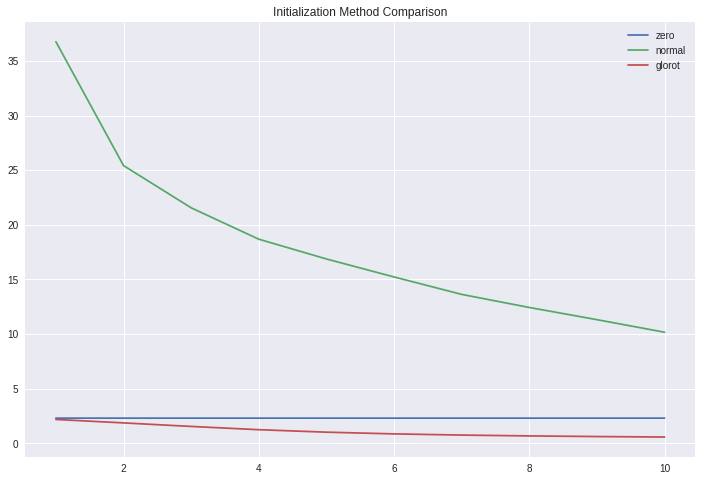

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Initialization Method Comparison')
plt.plot(range(1, 11), zero_losses, label='zero')
plt.plot(range(1, 11), normal_losses, label='normal')
plt.plot(range(1, 11), glorot_losses, label='glorot')
plt.legend()
plt.show()

### Hyperparameter search with ``glorot`` initialization

We look at a few hyperparaneter combinations, and note that ``relu`` activation with ``learning_rate=0.1`` and ``batch_size=200`` achieves more than $97\%$ accuracy on the validation set. We also try some other combinations and see that they all achieve more than $90\%$ validation accuracy.

In [ ]:
nn = NN(datapath='mnist.pkl.gz', hidden_dims=(512, 1024))
#params = nn.initialize_weights()
#params['n_params']
out = nn.train(nn.X_train, nn.y_train, learning_rate=0.1, activation_function='relu', batch_size=200)

Epoch 1/10 - loss: 0.5384 - acc: 0.8999 - val_acc: 0.9128
Epoch 2/10 - loss: 0.2626 - acc: 0.9296 - val_acc: 0.9352
Epoch 3/10 - loss: 0.2066 - acc: 0.9453 - val_acc: 0.9488
Epoch 4/10 - loss: 0.1709 - acc: 0.9553 - val_acc: 0.9566
Epoch 5/10 - loss: 0.1453 - acc: 0.9622 - val_acc: 0.9612
Epoch 6/10 - loss: 0.1258 - acc: 0.9681 - val_acc: 0.9648
Epoch 7/10 - loss: 0.1103 - acc: 0.9718 - val_acc: 0.9683
Epoch 8/10 - loss: 0.0976 - acc: 0.9753 - val_acc: 0.9703
Epoch 9/10 - loss: 0.0870 - acc: 0.9779 - val_acc: 0.9708
Epoch 10/10 - loss: 0.0779 - acc: 0.9804 - val_acc: 0.9719
Maximum epochs reached. Exiting...


In [ ]:
out = nn.train(nn.X_train, nn.y_train, learning_rate=0.05, activation_function='relu', batch_size=200)

Epoch 1/10 - loss: 0.7128 - acc: 0.8926 - val_acc: 0.9049
Epoch 2/10 - loss: 0.3247 - acc: 0.9151 - val_acc: 0.9239
Epoch 3/10 - loss: 0.2709 - acc: 0.9288 - val_acc: 0.9337
Epoch 4/10 - loss: 0.2370 - acc: 0.9375 - val_acc: 0.9429
Epoch 5/10 - loss: 0.2113 - acc: 0.9443 - val_acc: 0.9486
Epoch 6/10 - loss: 0.1904 - acc: 0.9492 - val_acc: 0.9529
Epoch 7/10 - loss: 0.1729 - acc: 0.9535 - val_acc: 0.9559
Epoch 8/10 - loss: 0.1581 - acc: 0.9572 - val_acc: 0.9589
Epoch 9/10 - loss: 0.1453 - acc: 0.9604 - val_acc: 0.9610
Epoch 10/10 - loss: 0.1342 - acc: 0.9634 - val_acc: 0.9637
Maximum epochs reached. Exiting...


In [ ]:
out = nn.train(nn.X_train, nn.y_train, learning_rate=0.01, activation_function='tanh', batch_size=200)

Epoch 1/10 - loss: 1.0775 - acc: 0.8489 - val_acc: 0.8684
Epoch 2/10 - loss: 0.5411 - acc: 0.8750 - val_acc: 0.8885
Epoch 3/10 - loss: 0.4447 - acc: 0.8862 - val_acc: 0.8995
Epoch 4/10 - loss: 0.4008 - acc: 0.8933 - val_acc: 0.9053
Epoch 5/10 - loss: 0.3745 - acc: 0.8987 - val_acc: 0.9086
Epoch 6/10 - loss: 0.3564 - acc: 0.9021 - val_acc: 0.9129
Epoch 7/10 - loss: 0.3428 - acc: 0.9050 - val_acc: 0.9144
Epoch 8/10 - loss: 0.3320 - acc: 0.9077 - val_acc: 0.9167
Epoch 9/10 - loss: 0.3230 - acc: 0.9097 - val_acc: 0.9178
Epoch 10/10 - loss: 0.3152 - acc: 0.9115 - val_acc: 0.9189
Maximum epochs reached. Exiting...


In [ ]:
out = nn.train(nn.X_train, nn.y_train, learning_rate=0.1, activation_function='relu', batch_size=400)

Epoch 1/10 - loss: 0.7303 - acc: 0.8899 - val_acc: 0.9047
Epoch 2/10 - loss: 0.3289 - acc: 0.9143 - val_acc: 0.9233
Epoch 3/10 - loss: 0.2717 - acc: 0.9296 - val_acc: 0.9356
Epoch 4/10 - loss: 0.2360 - acc: 0.9390 - val_acc: 0.9441
Epoch 5/10 - loss: 0.2092 - acc: 0.9460 - val_acc: 0.9500
Epoch 6/10 - loss: 0.1879 - acc: 0.9510 - val_acc: 0.9540
Epoch 7/10 - loss: 0.1703 - acc: 0.9550 - val_acc: 0.9574
Epoch 8/10 - loss: 0.1555 - acc: 0.9590 - val_acc: 0.9599
Epoch 9/10 - loss: 0.1428 - acc: 0.9625 - val_acc: 0.9631
Epoch 10/10 - loss: 0.1319 - acc: 0.9653 - val_acc: 0.9650
Maximum epochs reached. Exiting...


In [ ]:
out = nn.train(nn.X_train, nn.y_train, learning_rate=0.01, activation_function='tanh', batch_size=400)

Epoch 1/10 - loss: 1.3997 - acc: 0.8100 - val_acc: 0.8367
Epoch 2/10 - loss: 0.7443 - acc: 0.8484 - val_acc: 0.8697
Epoch 3/10 - loss: 0.5800 - acc: 0.8649 - val_acc: 0.8816
Epoch 4/10 - loss: 0.5045 - acc: 0.8741 - val_acc: 0.8884
Epoch 5/10 - loss: 0.4602 - acc: 0.8803 - val_acc: 0.8945
Epoch 6/10 - loss: 0.4307 - acc: 0.8857 - val_acc: 0.8989
Epoch 7/10 - loss: 0.4094 - acc: 0.8896 - val_acc: 0.9006
Epoch 8/10 - loss: 0.3931 - acc: 0.8929 - val_acc: 0.9016
Epoch 9/10 - loss: 0.3801 - acc: 0.8956 - val_acc: 0.9045
Epoch 10/10 - loss: 0.3695 - acc: 0.8979 - val_acc: 0.9056
Maximum epochs reached. Exiting...


### Validate gradients with finite gradient check

We compute finite difference gradients and check how well they approximate the gradients for a random data point. From the plot, we check see that our finite difference gradients are pretty good approximations.

In [ ]:
np.random.choice([k*10**i for i in range(6) for k in [1,5]],
                      5, replace=False)

array([  1000, 500000,     50,  50000,  10000])

In [ ]:
# load the model
nn = NN(datapath='mnist.pkl.gz', hidden_dims=(512, 768))
# values of N
Ns = sorted(np.random.choice([k*10**i for i in range(6) for k in [1,5]], 5, replace=False))
# obtain one random datapoint
np.random.seed(0)
i = np.random.randint(0, nn.X_train.shape[0])
X, y = nn.X_train[i:(i+1)], nn.y_train[i:(i+1)]
# compute forward and backward prop and the gradient
params = nn.initialize_weights()
cache = nn.forward(X, params)
grads = nn.backward(X, y, params, cache)
# take the first 10 parameters 
grad_theta = grads['grad_W2'][:10, 0]
differences = []
for N in Ns:
    eps = 1 / N
    grad_diff = np.zeros(10)
    for i in range(10):
        # compute finite difference
        params['W2'][i, 0] += eps
        cache = nn.forward(X, params)
        # add epsilon 
        l_pos = nn.loss(y, cache["Z"+str(nn.n_hidden+1)])
        # subtract epsilon
        params['W2'][i, 0] -= 2 * eps
        cache = nn.forward(X, params)
        l_neg = nn.loss(y, cache["Z"+str(nn.n_hidden+1)])
        # reset value
        params['W2'][i, 0] += eps
        # Finite Diff
        grad_diff[i] = (l_pos - l_neg) / (2 * eps)
    differences.append(np.max(np.abs(grad_theta - grad_diff)))

In [ ]:
Ns, differences

([10, 50, 5000, 50000, 500000],
 [0.01071417955257601,
  1.252289438813392e-09,
  9.091642369507547e-13,
  1.473225361148245e-11,
  1.1899492242256615e-10])

Text(0.5, 1.0, 'Gradient Difference')

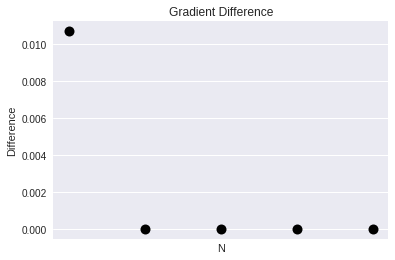

In [ ]:
plt.plot(range(5), differences, 'k.', markersize=20)
plt.xlabel('N')
plt.ylabel('Difference')
plt.xticks([])
plt.title('Gradient Difference')